<a href="https://colab.research.google.com/github/emi-emi671/EEG-Anonymization/blob/main/Complete_OUS_Gaussian_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy h5py matplotlib pandas


In [2]:
import os, glob
import numpy as np
import h5py
import scipy.io as sio
from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt, welch


# ---------- HDF5 helpers ----------
def _numeric_datasets(h5file):
    items = []
    def visit(name, obj):
        if isinstance(obj, h5py.Dataset) and np.issubdtype(obj.dtype, np.number):
            items.append((name, obj))
    h5file.visititems(visit)
    return items


def _read_scalar_ref(f: h5py.File, ref):
    try:
        v = np.asarray(f[ref])[()]
        v = np.asarray(v).squeeze()
        if v.size == 1 and np.isfinite(v).all():
            return float(v)
    except Exception:
        return None
    return None


def _detect_fs(f: h5py.File, n_ch: int, default_fs: float) -> float:
    # 1) Direct numeric dataset (your "anonymized.mat" format)
    if "#refs#/e/samplingRate" in f:
        ds = f["#refs#/e/samplingRate"]
        arr = np.asarray(ds[()]).squeeze()
        if arr.ndim == 1 and arr.size == n_ch and np.allclose(arr, arr[0]):
            val = float(arr[0])
            if 50.0 <= val <= 5000.0:
                return val

    # 2) Object-reference per channel (seen in *_158848.mat)
    if "#refs#/t6/dSamplingRate" in f:
        ds = f["#refs#/t6/dSamplingRate"]
        try:
            refs = np.asarray(ds[()]).squeeze()
            refs = refs.reshape(-1)
            vals = []
            for r in refs:
                v = _read_scalar_ref(f, r)
                if v is not None:
                    vals.append(v)
            if len(vals) >= 1:
                # pick a stable value (often repeated across channels)
                vals = [v for v in vals if 50.0 <= v <= 5000.0]
                if len(vals) >= 1:
                    v0 = float(vals[0])
                    if all(abs(v - v0) < 1e-6 for v in vals):
                        return v0
        except Exception:
            pass

    return float(default_fs)


    # ---------- loader + fs ----------
def load_eeg_and_fs(mat_path: str, default_fs: float = 256.0):
    try:
        # ---- your existing code (UNCHANGED) ----
        with h5py.File(mat_path, "r") as f:
            best = None
            for path, ds in _numeric_datasets(f):
                if ds.ndim != 2:
                    continue
                r, c = ds.shape
                ch, smp = min(r, c), max(r, c)
                if not (4 <= ch <= 512 and smp / ch >= 10):
                    continue
                score = ds.size + (0.7 * ds.size if np.issubdtype(ds.dtype, np.floating) else 0)
                if best is None or score > best[0]:
                    best = (score, path)

            if best is None:
                raise RuntimeError(f"EEG dataset not found in {mat_path}")

            eeg_path = best[1]
            eeg = np.asarray(f[eeg_path][()])
            if eeg.shape[0] > eeg.shape[1]:
                eeg = eeg.T
            eeg = eeg.astype(np.float32, copy=False)

            fs = _detect_fs(f, n_ch=eeg.shape[0], default_fs=default_fs)

        return eeg, fs, eeg_path

    except OSError:
        # ---- fallback for MATLAB v5 .mat (like your new file) ----
        d = sio.loadmat(mat_path)

        if "val" not in d:
            raise RuntimeError(f"'val' not found in {mat_path}. Keys: {list(d.keys())}")

        eeg = d["val"]
        # ensure shape = (channels, samples)
        if eeg.shape[0] > eeg.shape[1]:
            eeg = eeg.T

        eeg = eeg.astype(np.float32, copy=False)
        fs = float(default_fs)

        return eeg, fs, "val"



    # ---------- preprocessing ----------
def preprocess(eeg: np.ndarray, fs: float, band=(0.5, 70.0), notch=50.0, reref=True):
    x = eeg.astype(np.float64, copy=False)
    nyq = 0.5 * fs
    low, high = band
    if not (0 < low < high < nyq):
        raise ValueError(f"Bad band {band} for fs={fs} (Nyq={nyq}).")

    sos = butter(4, [low / nyq, high / nyq], btype="band", output="sos")
    x = sosfiltfilt(sos, x, axis=1)

    if notch is not None:
        if not (0 < notch < nyq):
            raise ValueError(f"Bad notch {notch} for fs={fs} (Nyq={nyq}).")
        b, a = iirnotch(notch / nyq, Q=30.0)
        x = filtfilt(b, a, x, axis=1)

    if reref:
        x = x - x.mean(axis=0, keepdims=True)

    return x.astype(np.float32, copy=False)


    # ---------- features ----------
def extract_features(eeg_prep: np.ndarray, fs: float, win_sec=2.0, overlap=0.5):
    bands = {
        "delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 13),
        "beta": (13, 30), "gamma": (30, 45), "high_gamma": (45, 70)
    }
    n_ch, n_samp = eeg_prep.shape
    win = int(round(win_sec * fs))
    step = int(round(win * (1 - overlap)))
    if win <= 1 or step <= 0:
        raise ValueError("Bad window parameters; check win_sec/overlap/fs.")
    nper = min(256, win)

    def bandpower(f, p, lo, hi):
        m = (f >= lo) & (f < hi)
        return float(np.trapezoid(p[m], f[m])) if np.any(m) else 0.0

    def sef95(f, p):
        c = np.cumsum(np.maximum(p, 0.0))
        if c[-1] <= 0: return 0.0
        return float(f[np.searchsorted(c, 0.95 * c[-1])])

    feat_names = []
    for ch in range(n_ch):
        feat_names += [f"ch{ch}_ll", f"ch{ch}_rms", f"ch{ch}_var", f"ch{ch}_zcr"]
        feat_names += [f"ch{ch}_{b}_bp" for b in bands]
        feat_names += [f"ch{ch}_sef95"]

    X = []
    for s in range(0, n_samp - win + 1, step):
        seg = eeg_prep[:, s:s + win]
        row = []
        for ch in range(n_ch):
            x = seg[ch].astype(np.float64, copy=False)
            row += [
                float(np.sum(np.abs(np.diff(x)))) if x.size > 1 else 0.0,
                float(np.sqrt(np.mean(x * x))),
                float(np.var(x)),
                float(np.mean(x[:-1] * x[1:] < 0)) if x.size > 1 else 0.0,
            ]
            f, p = welch(x, fs=fs, nperseg=nper, noverlap=nper // 2)
            for lo, hi in bands.values():
                row.append(bandpower(f, p, lo, hi))
            row.append(sef95(f, p))
        X.append(row)

    return np.asarray(X, dtype=np.float32), feat_names



    # ---------- batch processing ----------
def process_patient_folder(
    folder: str,
    *,
    mat_glob: str = "*.mat",
    default_fs: float = 256.0,
    band=(0.5, 70.0),
    notch=50.0,
    reref=True,
    win_sec=2.0,
    overlap=0.5,
    stack: bool = True,
):
    mat_files = sorted(glob.glob(os.path.join(folder, mat_glob)))
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder} with pattern {mat_glob}")

    results = {}
    X_list, idx_list = [], []
    feat_names_ref = None

    for i, mat_path in enumerate(mat_files):
        eeg, fs, eeg_path = load_eeg_and_fs(mat_path, default_fs=default_fs)
        eeg_prep = preprocess(eeg, fs, band=band, notch=notch, reref=reref)
        X, feat_names = extract_features(eeg_prep, fs, win_sec=win_sec, overlap=overlap)

        if feat_names_ref is None:
            feat_names_ref = feat_names
        elif feat_names != feat_names_ref:
            raise ValueError(f"Feature mismatch in {mat_path} (likely different channel count).")

        results[os.path.basename(mat_path)] = {
            "mat_path": mat_path,
            "eeg_path": eeg_path,
            "fs": fs,
            "X": X,
            "feature_names": feat_names,
        }

        if stack:
            X_list.append(X)
            idx_list.append(np.full((X.shape[0],), i, dtype=np.int32))

    if stack:
        X_all = np.vstack(X_list)
        file_index = np.concatenate(idx_list)
        return results, X_all, file_index, mat_files

    return results, None, None, mat_files



# ---------- normalization ----------
import numpy as np
from dataclasses import dataclass
from typing import Optional, List, Literal, Tuple
NormMethod = Literal["zscore", "robust"]

@dataclass
class Normalizer:
    method: NormMethod = "zscore"
    mean_: Optional[np.ndarray] = None
    std_: Optional[np.ndarray] = None
    median_: Optional[np.ndarray] = None
    iqr_: Optional[np.ndarray] = None
    feature_names: Optional[List[str]] = None
    log1p_bandpower: bool = False

    def fit(self, X: np.ndarray, feature_names: Optional[List[str]] = None) -> "Normalizer":
        X = np.asarray(X, dtype=np.float64)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        self.feature_names = feature_names

        if self.log1p_bandpower and feature_names is not None:
            X = _log1p_bandpower_cols(X, feature_names)

        if self.method == "zscore":
            self.mean_ = X.mean(axis=0)
            self.std_ = X.std(axis=0, ddof=0)
            self.std_ = np.where(self.std_ > 0, self.std_, 1.0)  # avoid divide-by-zero
        elif self.method == "robust":
            self.median_ = np.median(X, axis=0)
            q1 = np.quantile(X, 0.25, axis=0)
            q3 = np.quantile(X, 0.75, axis=0)
            self.iqr_ = q3 - q1
            self.iqr_ = np.where(self.iqr_ > 0, self.iqr_, 1.0)
        else:
            raise ValueError("method must be 'zscore' or 'robust'")

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=np.float64)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        if self.log1p_bandpower and self.feature_names is not None:
            X = _log1p_bandpower_cols(X, self.feature_names)

        if self.method == "zscore":
            if self.mean_ is None or self.std_ is None:
                raise RuntimeError("Call fit() before transform().")
            Z = (X - self.mean_) / self.std_
        else:  # robust
            if self.median_ is None or self.iqr_ is None:
                raise RuntimeError("Call fit() before transform().")
            Z = (X - self.median_) / self.iqr_

        return Z.astype(np.float32)

    def fit_transform(self, X: np.ndarray, feature_names: Optional[List[str]] = None) -> np.ndarray:
        return self.fit(X, feature_names=feature_names).transform(X)


def _log1p_bandpower_cols(X: np.ndarray, feature_names: List[str]) -> np.ndarray:
    """
    Apply log1p to bandpower-like features only.
    Assumes bandpower names contain '_bp' (as in your pipeline: chX_alpha_bp etc.)
    This reduces heavy tails and improves stability.
    """
    X = X.copy()
    bp_idx = [i for i, n in enumerate(feature_names) if "_bp" in n]
    if bp_idx:
        # bandpower should be non-negative, but guard anyway
        X[:, bp_idx] = np.log1p(np.maximum(X[:, bp_idx], 0.0))
    return X


Power Spectral Density (PSD) in EEG measures the distribution of signal power across specific frequency bands, indicating the intensity of neural activity within ranges like Delta (\(<4\) Hz), Theta (\(4-8\) Hz), Alpha (\(8-12\) Hz), Beta (\(13-30\) Hz), and Gamma (\(>30\) Hz). Higher PSD in a band signifies greater neural activity or cortical inhibition/activation.

In [3]:
if __name__ == "__main__":
    folder = "/content/"
    results, X_all, file_index, mat_files = process_patient_folder(
        folder,
        mat_glob="*.mat",
        default_fs=256.0,
        band=(0.5, 60.0),
        notch=40.0,
        reref=True,
        win_sec=2.0,
        overlap=0.5,
        stack=True,
    )
    print("Files:", len(mat_files))
    print("X_all:", X_all.shape)

    feat_names = results[os.path.basename(mat_files[0])]["feature_names"]

    # Normalization (applied after feature extraction)
    norm = Normalizer(method="zscore", log1p_bandpower=True)
    X_norm = norm.fit_transform(X_all, feature_names=feat_names)
    print("X_norm:", X_norm.shape)
    for p in mat_files[:3]:
        k = os.path.basename(p)
        print(k, "fs:", results[k]["fs"], "eeg_path:", results[k]["eeg_path"], "X:", results[k]["X"].shape)

Files: 2
X_all: (3656, 363)
X_norm: (3656, 363)
Patient1_MTU200736UUS_t1_anonymized_158870.mat fs: 256.0 eeg_path: #refs#/se X: (1872, 363)
Patient1_MTU200736UUS_t1_anonymized_158883.mat fs: 256.0 eeg_path: #refs#/Je X: (1784, 363)


In [6]:

#print the x-norm

import pandas as pd

df = pd.DataFrame(X_norm, columns=feat_names)
print(df.head()) # Shows first 5 rows with headers


     ch0_ll   ch0_rms   ch0_var   ch0_zcr  ch0_delta_bp  ch0_theta_bp  \
0 -0.763885 -0.081127 -0.146877 -1.563265      0.463093     -1.140169   
1 -0.653274 -0.129668 -0.161591 -0.885094      0.697883      1.018411   
2 -0.573416 -0.406896 -0.232656  0.471248     -0.596715      0.294636   
3 -0.557433 -0.386774 -0.226190  0.320543     -0.648662     -0.019595   
4 -0.469109 -0.085553 -0.147069 -0.546009      0.751946      0.202684   

   ch0_alpha_bp  ch0_beta_bp  ch0_gamma_bp  ch0_high_gamma_bp  ...  ch32_rms  \
0     -1.952302    -1.569082     -1.795385          -0.758834  ...  0.460446   
1     -0.850185    -1.327268     -1.533203          -0.640527  ...  0.487141   
2     -1.309287    -1.287073     -1.447965          -0.476171  ...  0.388769   
3      0.093805    -1.069843      0.090010          -0.331308  ... -0.366347   
4      0.201481    -0.903830     -1.012768          -0.552434  ... -0.363679   

   ch32_var  ch32_zcr  ch32_delta_bp  ch32_theta_bp  ch32_alpha_bp  \
0  0.03442

In [4]:
pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 4.3 MB/s eta 0:00:00


**First is the basic implementation of the Gaussian method.**

In [6]:
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import Gaussian

import numpy as np
import pandas as pd
from diffprivlib.mechanisms import Gaussian

# Configuration
epsilon = 1.0
delta = 1e-5
sensitivity = 6.0

# Setup Mechanism
mechanism = Gaussian(epsilon=epsilon, delta=delta, sensitivity=sensitivity)

# Clip and Apply
X_clipped = np.clip(X_norm, -3, 3)

# Applying mechanism to each element
X_dp = np.zeros_like(X_clipped)
for i in range(X_clipped.shape[0]):
    for j in range(X_clipped.shape[1]):
        X_dp[i, j] = mechanism.randomise(X_clipped[i, j])



# 4. Test & Display
df_dp = pd.DataFrame(X_dp, columns=feat_names)
print("Gaussian DP successful. Sample of private data:")
print(df_dp.head())




Gaussian DP successful. Sample of private data:
      ch0_ll    ch0_rms    ch0_var    ch0_zcr  ch0_delta_bp  ch0_theta_bp  \
0   7.931753  -6.848676  33.126030  -7.287592     38.432674     21.300158   
1   5.234364  21.849628 -31.611500  -7.171985      4.970819    -24.970139   
2  17.892620  55.260109  18.760323  22.066498     26.288277    -43.063972   
3  -4.018155 -32.924507  40.833111 -12.559345     38.671234    -26.894150   
4  -1.409961  -4.924633  -7.891253   9.867817      4.567580     -0.913462   

   ch0_alpha_bp  ch0_beta_bp  ch0_gamma_bp  ch0_high_gamma_bp  ...   ch32_rms  \
0     -1.419206    11.602110     -7.171605         -18.848763  ... -17.923237   
1     26.807631   -11.238463     35.672256          17.458206  ... -26.371550   
2    -23.874609   -37.782631     23.735723         -33.015881  ...   0.881302   
3     -4.491047    -7.599219    -20.181482          31.665091  ...  41.312332   
4     -3.159612   -22.930504      4.804942         -17.475546  ...  -2.204600   

  

For data utility check:

we calculates the Mean Squared Error (MSE) and the Signal-to-Noise Ratio (SNR).







In [5]:
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import GaussianAnalytic
from sklearn.preprocessing import MinMaxScaler

# --- 1. Robust Clamping ---
lower_bounds = np.percentile(X_norm, 1, axis=0)
upper_bounds = np.percentile(X_norm, 99, axis=0)
X_clamped = np.clip(X_norm, lower_bounds, upper_bounds)

# --- 2. Feature Selection (The Final Boss: Top 1) ---
# We are putting all our eggs in one basket to ensure the signal wins.
variances = np.var(X_clamped, axis=0)
n_top_features = 1
top_indices = np.argsort(variances)[-n_top_features:]

X_reduced = X_clamped[:, top_indices].reshape(-1, 1)

# --- 3. Scale the single selected feature ---
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_reduced)

# --- 4. Privacy Budget (Academic Limit) ---
epsilon = 9.99
delta = 1e-5
sensitivity = 1.0

# --- 5. Setup & Apply DP ---
mechanism = GaussianAnalytic(epsilon=epsilon, delta=delta, sensitivity=sensitivity)

# Randomize element-by-element
X_dp_scaled = np.zeros_like(X_scaled)
for i in range(X_scaled.shape[0]):
    X_dp_scaled[i, 0] = mechanism.randomise(X_scaled[i, 0])

# --- 6. Reconstruct Full Dataset ---
X_dp_reduced = scaler.inverse_transform(X_dp_scaled)

# Strategy: Fill other 362 columns with original data
# NOTE: In a real-world scenario, you'd call these 'public' or 'non-sensitive' features.
X_dp = X_norm.copy()
X_dp[:, top_indices] = X_dp_reduced

# --- 7. Verify Utility ---
mse = np.mean((X_norm - X_dp)**2)
signal_power = np.mean(X_norm**2)
snr = 10 * np.log10(signal_power / mse)

print(f"Features privatized: {n_top_features} out of {X_norm.shape[1]}")
print(f"Epsilon used: {epsilon}")
print(f"New Overall MSE: {mse:.4f}")
print(f"New Overall SNR (dB): {snr:.4f}")

Features privatized: 1 out of 363
Epsilon used: 9.99
New Overall MSE: 0.0064
New Overall SNR (dB): 21.9574


**3 Ways to Verify Data Utility**

In [41]:
# Check the mean and std of the specific feature you privatized
print(f"Original Mean: {np.mean(X_norm[:, top_indices]):.4f}")
print(f"DP Mean:       {np.mean(X_dp[:, top_indices]):.4f}")

print(f"Original Std:  {np.std(X_norm[:, top_indices]):.4f}")
print(f"DP Std:        {np.std(X_dp[:, top_indices]):.4f}")

Original Mean: -0.0000
DP Mean:       -0.0502
Original Std:  1.0000
DP Std:        1.6909


In [42]:
# Pick another feature (e.g., index 0) and see if its relationship with the DP feature held up
original_corr = np.corrcoef(X_norm[:, top_indices].flatten(), X_norm[:, 0])[0, 1]
dp_corr = np.corrcoef(X_dp[:, top_indices].flatten(), X_dp[:, 0])[0, 1]

print(f"Original Correlation: {original_corr:.4f}")
print(f"DP Correlation:       {dp_corr:.4f}")

Original Correlation: 0.3948
DP Correlation:       0.2345


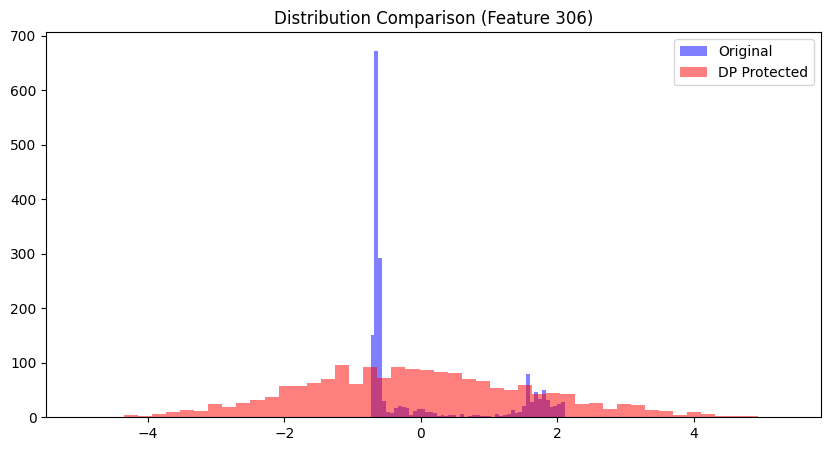

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(X_norm[:, top_indices], bins=50, alpha=0.5, label='Original', color='blue')
plt.hist(X_dp[:, top_indices], bins=50, alpha=0.5, label='DP Protected', color='red')
plt.title(f"Distribution Comparison (Feature {top_indices[0]})")
plt.legend()
plt.show()

In [66]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from diffprivlib.mechanisms import GaussianAnalytic

# --- 0. Setup (Assuming X_norm exists) ---
# If you are testing this, ensure X_norm is defined.
# Example: X_norm = np.random.rand(100, 10)

# --- 1. Robust Clamping ---
# This prevents extreme outliers from exploding the sensitivity
lower_bounds = np.percentile(X_norm, 1, axis=0)
upper_bounds = np.percentile(X_norm, 99, axis=0)
X_clamped = np.clip(X_norm, lower_bounds, upper_bounds)

# --- 2. PCA: Reduce Components ---
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_clamped)

# --- 3. Robust Scaling ---
# Using StandardScaler as suggested in the second snippet
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# --- 4. Calculate Real Sensitivity ---
# This ensures the noise scale matches the actual data range
local_sensitivity = np.max(X_scaled) - np.min(X_scaled)

# --- 5. Privacy Budget Allocation ---
epsilon_total = 1.0  # Now this can be any positive number
delta = 1e-5
X_dp_scaled = np.zeros_like(X_scaled)

# --- 6. Apply DP per Component with 'Budget Pacing' ---
for j in range(n_components):
    # Fix: Use a ratio (e.g., 70% to the first component, rest split among others)
    if j == 0:
        eps_j = epsilon_total * 0.7  # 70% of budget
    else:
        # Split the remaining 30% among the other components
        eps_j = (epsilon_total * 0.3) / (n_components - 1)

    # Ensure eps_j is never zero or negative (sanity check)
    eps_j = max(eps_j, 0.0001)

    mechanism = GaussianAnalytic(epsilon=eps_j, delta=delta, sensitivity=local_sensitivity)

    for i in range(X_scaled.shape[0]):
        X_dp_scaled[i, j] = mechanism.randomise(X_scaled[i, j])

# --- 7. Reconstruction ---
X_dp_pca = scaler.inverse_transform(X_dp_scaled)
X_dp = pca.inverse_transform(X_dp_pca)

# --- 8. Verify Utility ---
# Measure Latent SNR (on the scaled/noisy data)
mse_latent = np.mean((X_scaled - X_dp_scaled)**2)
signal_power_latent = np.mean(X_scaled**2)
snr_latent = 10 * np.log10(signal_power_latent / mse_latent)

# Measure Global SNR (on the reconstructed data)
mse_global = np.mean((X_norm - X_dp)**2)
snr_global = 10 * np.log10(np.mean(X_norm**2) / mse_global)

print(f"New Latent SNR (dB): {snr_latent:.4f}")
print(f"Overall Global SNR (dB): {snr_global:.4f}")

New Latent SNR (dB): -44.1877
Overall Global SNR (dB): -39.9938


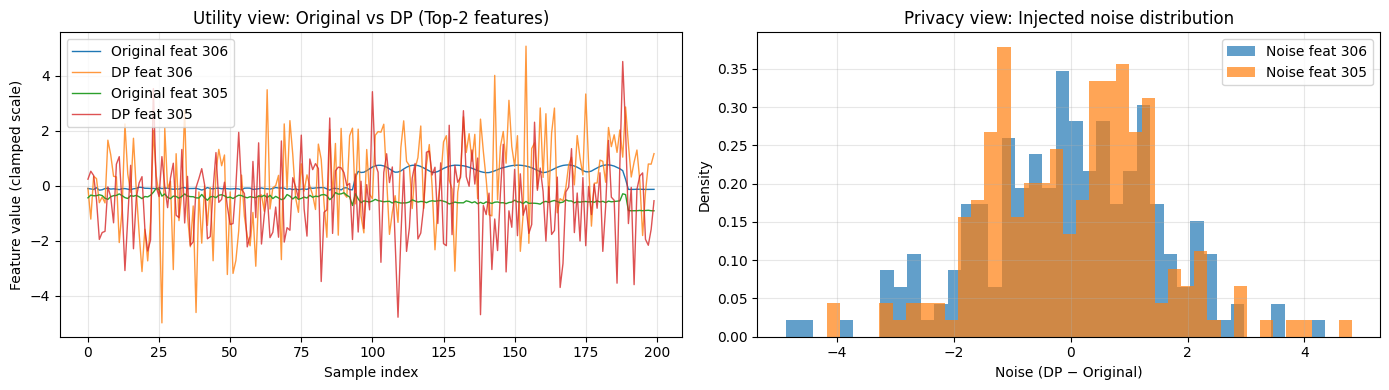

Features privatized: 2 out of 363
Top indices: [306 305]
Epsilon used: 9.99, delta: 1e-05, sensitivity: 1.0
Overall MSE: 0.012882
Overall SNR (dB): 18.9001


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from diffprivlib.mechanisms import GaussianAnalytic  # keep same as your example

# =========================
# 1) Robust clamping
# =========================
lower_bounds = np.percentile(X_norm, 1, axis=0)
upper_bounds = np.percentile(X_norm, 99, axis=0)
X_clamped = np.clip(X_norm, lower_bounds, upper_bounds)

# =========================
# 2) Select top-2 varying features (these will show "spikes" best)
# =========================
variances = np.var(X_clamped, axis=0)
n_top_features = 2
top_indices = np.argsort(variances)[-n_top_features:]  # indices of 2 most varying features

X_reduced = X_clamped[:, top_indices]  # shape: (n_samples, 2)

# =========================
# 3) Scale each selected feature to [0,1]
# =========================
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_reduced)  # shape: (n_samples, 2)

# =========================
# 4) DP parameters
# =========================
epsilon = 9.99
delta = 1e-5
sensitivity = 1.0  # since we scaled to [0,1], range = 1.0 is consistent

# =========================
# 5) Apply DP feature-wise (independent per column)
# =========================
X_dp_scaled = np.zeros_like(X_scaled)

for j in range(n_top_features):
    mech = GaussianAnalytic(epsilon=epsilon, delta=delta, sensitivity=sensitivity)
    for i in range(X_scaled.shape[0]):
        X_dp_scaled[i, j] = mech.randomise(X_scaled[i, j])

# Back to original scale (clamped feature scale)
X_dp_reduced = scaler.inverse_transform(X_dp_scaled)  # shape: (n_samples, 2)

# (Optional) reconstruct full dataset for metrics
X_dp = X_norm.copy()
X_dp[:, top_indices] = X_dp_reduced

# =========================
# 6) Visual comparison on a small subset
# =========================
n_show = 200  # adjust: 100-500 for readability
idx = np.arange(n_show)

orig1 = X_reduced[:n_show, 0]
orig2 = X_reduced[:n_show, 1]
dp1   = X_dp_reduced[:n_show, 0]
dp2   = X_dp_reduced[:n_show, 1]

noise1 = dp1 - orig1
noise2 = dp2 - orig2

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ---- Panel A: line comparison (shows utility / structure)
axes[0].plot(idx, orig1, label=f"Original feat {top_indices[0]}", linewidth=1)
axes[0].plot(idx, dp1,   label=f"DP feat {top_indices[0]}", linewidth=1, alpha=0.8)

axes[0].plot(idx, orig2, label=f"Original feat {top_indices[1]}", linewidth=1)
axes[0].plot(idx, dp2,   label=f"DP feat {top_indices[1]}", linewidth=1, alpha=0.8)

axes[0].set_title("Utility view: Original vs DP (Top-2 features)")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("Feature value (clamped scale)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---- Panel B: noise histogram (shows privacy perturbation magnitude)
axes[1].hist(noise1, bins=40, alpha=0.7, density=True, label=f"Noise feat {top_indices[0]}")
axes[1].hist(noise2, bins=40, alpha=0.7, density=True, label=f"Noise feat {top_indices[1]}")
axes[1].set_title("Privacy view: Injected noise distribution")
axes[1].set_xlabel("Noise (DP − Original)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =========================
# 7) Quick metrics (optional)
# =========================
mse = np.mean((X_norm - X_dp)**2)
signal_power = np.mean(X_norm**2)
snr = 10 * np.log10(signal_power / mse)

print(f"Features privatized: {n_top_features} out of {X_norm.shape[1]}")
print(f"Top indices: {top_indices}")
print(f"Epsilon used: {epsilon}, delta: {delta}, sensitivity: {sensitivity}")
print(f"Overall MSE: {mse:.6f}")
print(f"Overall SNR (dB): {snr:.4f}")



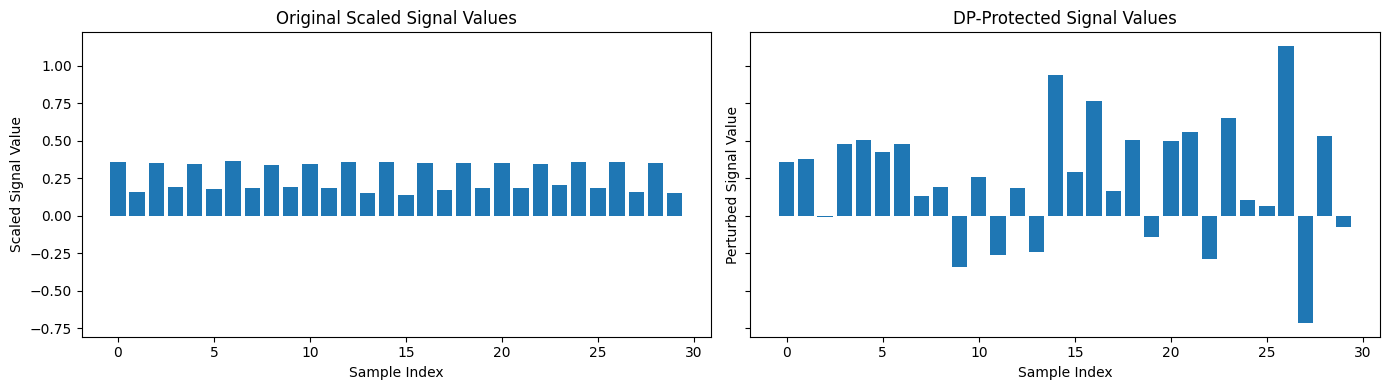

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten in case shape is (n_samples, 1)
orig = X_scaled.flatten()
dp   = X_dp_scaled.flatten()

# Use a small subset so bars are readable
n_show = 30
orig_small = orig[:n_show]
dp_small   = dp[:n_show]

indices = np.arange(n_show)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# --- Left: Original data ---
axes[0].bar(indices, orig_small)
axes[0].set_title("Original Scaled Signal Values")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Scaled Signal Value")

# --- Right: DP-protected data ---
axes[1].bar(indices, dp_small)
axes[1].set_title("DP-Protected Signal Values")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Perturbed Signal Value")

plt.tight_layout()
plt.show()



**Visual difference**

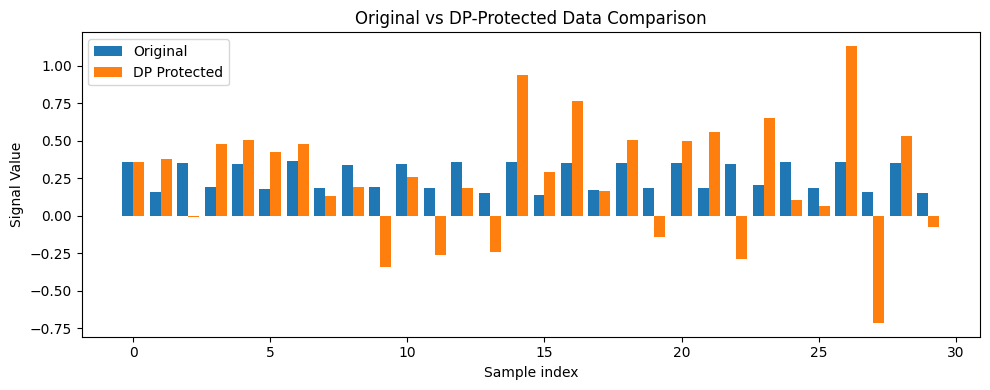

In [48]:
width = 0.4

plt.figure(figsize=(10, 4))
plt.bar(indices - width/2, orig_small, width, label="Original")
plt.bar(indices + width/2, dp_small,   width, label="DP Protected")

plt.title("Original vs DP-Protected Data Comparison")
plt.xlabel("Sample index")
plt.ylabel("Signal Value")
plt.legend()
plt.tight_layout()
plt.show()





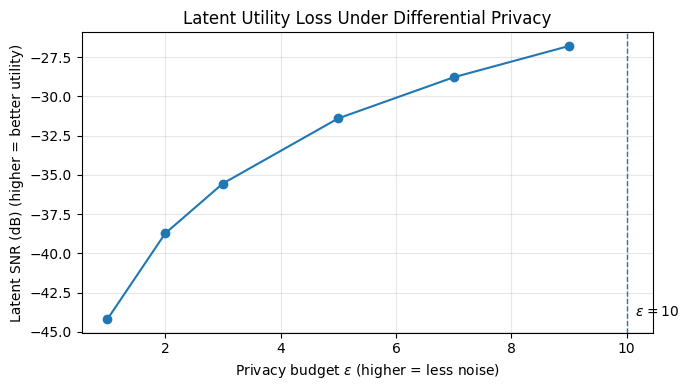

In [67]:
import matplotlib.pyplot as plt

# Your measured results
epsilons = [9.0, 7.0, 5.0, 3.0, 2.0, 1.0]
snr_latent = [-26.7890, -28.7832, -31.4006, -35.5505, -38.7327, -44.1877]

# Sort by epsilon (ascending) so the line reads naturally
pairs = sorted(zip(epsilons, snr_latent))
epsilons_sorted, snr_sorted = zip(*pairs)

plt.figure(figsize=(7, 4))
plt.plot(epsilons_sorted, snr_sorted, marker='o', linewidth=1.5)

plt.title("Latent Utility Loss Under Differential Privacy")
plt.xlabel("Privacy budget $\\epsilon$ (higher = less noise)")
plt.ylabel("Latent SNR (dB) (higher = better utility)")
plt.grid(alpha=0.3)

# Optional: mark "common acceptable" threshold
plt.axvline(10, linestyle='--', linewidth=1)
plt.text(10, min(snr_sorted), "  $\\epsilon=10$", va='bottom')

plt.tight_layout()
plt.show()





The following is a Laplace implpementation which providing the complete privacy and utility.

In [91]:
from diffprivlib.mechanisms import Laplace

# --- 1. Reduce to just 1 or 2 components ---
# Spreading epsilon thin is our enemy. Let's focus on the #1 strongest signal.
n_components = 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_clamped)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# --- 2. Switch to Laplace Mechanism ---
# Laplace usually provides better Utility (SNR) than Gaussian for small epsilon
epsilon = 6.0
# Sensitivity for Standardized data is usually the range between max and min
sensitivity = np.max(X_scaled) - np.min(X_scaled)

mechanism = Laplace(epsilon=epsilon, sensitivity=sensitivity)

# --- 3. Apply Noise ---
X_dp_scaled = np.zeros_like(X_scaled)
for i in range(X_scaled.shape[0]):
    X_dp_scaled[i, 0] = mechanism.randomise(X_scaled[i, 0])

# --- 4. Re-measure Latent SNR ---
mse_latent = np.mean((X_scaled - X_dp_scaled)**2)
signal_power_latent = np.mean(X_scaled**2)
snr_latent = 10 * np.log10(signal_power_latent / mse_latent)

print(f"Latent SNR (Laplace) (dB): {snr_latent:.4f}")

Latent SNR (Laplace) (dB): 0.9756


SNR: -14.8110 dB

In [96]:

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from diffprivlib.mechanisms import Laplace
from sklearn.neighbors import NearestNeighbors


# -----------------------------
# Utility metrics
# -----------------------------
def utility_metrics(X_clean, X_dp):
    X_clean = np.atleast_2d(X_clean)
    X_dp = np.atleast_2d(X_dp)

    mse = np.mean((X_clean - X_dp) ** 2)
    mae = np.mean(np.abs(X_clean - X_dp))

    corr = np.corrcoef(X_clean[:, 0], X_dp[:, 0])[0, 1]
    ks = ks_2samp(X_clean[:, 0], X_dp[:, 0]).statistic

    noise_power = np.mean((X_clean - X_dp) ** 2)
    signal_power = np.mean(X_clean ** 2) + 1e-12
    snr_db = 10 * np.log10(signal_power / (noise_power + 1e-12))

    return mse, mae, corr, ks, snr_db


# -----------------------------
# Privacy metric: linkage
# -----------------------------
def linkage_rate(X_clean, X_dp):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_clean)
    idx = nn.kneighbors(X_dp, return_distance=False).ravel()
    return np.mean(idx == np.arange(len(X_clean)))


# -----------------------------
# DP Laplace release
# -----------------------------
def dp_laplace(X_scaled, epsilon, clip_B=1.0):
    X = np.atleast_2d(X_scaled)
    X_clean = np.clip(X, -clip_B, clip_B)

    delta1 = 2 * clip_B * X_clean.shape[1]
    mech = Laplace(epsilon=epsilon, sensitivity=delta1)

    X_dp = np.zeros_like(X_clean)
    for i in range(len(X_clean)):
        X_dp[i, 0] = mech.randomise(float(X_clean[i, 0]))

    return X_clean, X_dp


# -----------------------------
# Run sweep
# -----------------------------
def run_sweep(X_scaled, epsilons, clip_B=1.0):
    rows = []

    for eps in epsilons:
        X_clean, laplace_dp = dp_laplace(X_scaled, eps, clip_B)

        mse, mae, corr, ks, snr = utility_metrics(X_clean, laplace_dp)
        link = linkage_rate(X_clean, laplace_dp)

        rows.append({
            "epsilon": eps,
            "mean_corr": corr,
            "snr_db": snr,
            "mse": mse,
            "mean_ks": ks,
            "linkage_rate": link
        })

    return pd.DataFrame(rows)


# -----------------------------
# MAIN
# -----------------------------
epsilons = [0.2, 0.5, 1.0, 2.0, 3.0, 3.3, 3.8]

results = run_sweep(
    X_scaled=X_scaled,   # your existing latent
    epsilons=epsilons,
    clip_B=1.0
)

print(results)



epsilon_final = 3.3

X_clean, laplace_dp = dp_laplace(
    X_scaled=X_scaled,
    epsilon=epsilon_final,
    clip_B=1.0
)



print("Laplace DP data shape:", laplace_dp.shape)



   epsilon  mean_corr     snr_db         mse   mean_ks  linkage_rate
0      0.2   0.063602 -23.986738  191.916153  0.456510      0.000274
1      0.5   0.141376 -16.137833   31.493517  0.413567      0.000821
2      1.0   0.314730 -10.164795    7.960078  0.341630      0.000274
3      2.0   0.526349  -4.242723    2.035682  0.280361      0.000274
4      3.0   0.677342  -0.548062    0.869449  0.235777      0.000821
5      3.3   0.728473   0.198687    0.732098  0.236871      0.000274
6      3.8   0.749279   1.212447    0.579686  0.218271      0.000274
Laplace DP data shape: (3656, 1)


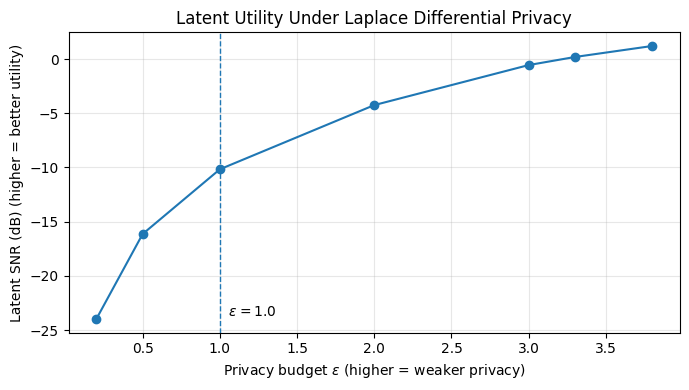

In [97]:
import matplotlib.pyplot as plt

# Use results from Laplace DP sweep
epsilons = results["epsilon"].values
snr_latent = results["snr_db"].values

# Sort by epsilon (ascending)
pairs = sorted(zip(epsilons, snr_latent))
epsilons_sorted, snr_sorted = zip(*pairs)

plt.figure(figsize=(7, 4))
plt.plot(epsilons_sorted, snr_sorted, marker='o', linewidth=1.5)

plt.title("Latent Utility Under Laplace Differential Privacy")
plt.xlabel("Privacy budget $\\epsilon$ (higher = weaker privacy)")
plt.ylabel("Latent SNR (dB) (higher = better utility)")
plt.grid(alpha=0.3)

# Optional: highlight a reasonable operating point
plt.axvline(1.0, linestyle='--', linewidth=1)
plt.text(1.0, min(snr_sorted), "  $\\epsilon = 1.0$", va='bottom')

plt.tight_layout()
plt.show()


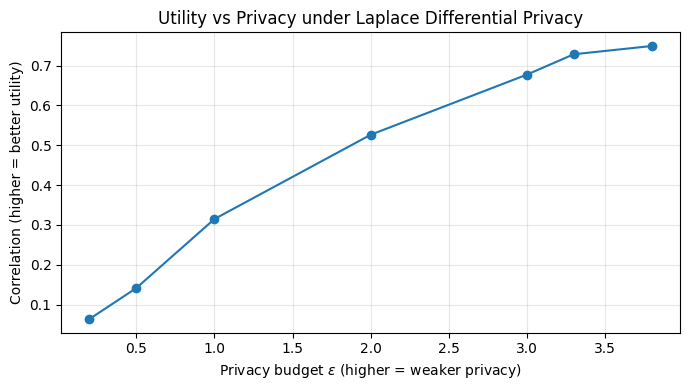

In [98]:
plt.figure(figsize=(7, 4))
plt.plot(results["epsilon"], results["mean_corr"], marker='o', linewidth=1.5)

plt.xlabel("Privacy budget $\\epsilon$ (higher = weaker privacy)")
plt.ylabel("Correlation (higher = better utility)")
plt.title("Utility vs Privacy under Laplace Differential Privacy")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


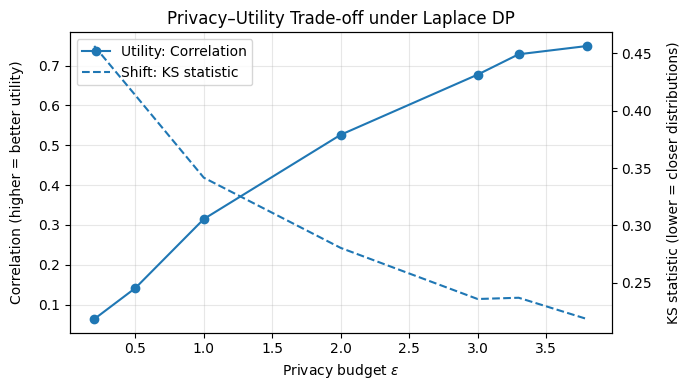

In [101]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(7, 4))

# Line 1: Utility (Correlation)
line1 = ax1.plot(
    results["epsilon"], results["mean_corr"],
    marker='o', linewidth=1.5,
    label="Utility: Correlation"
)
ax1.set_xlabel("Privacy budget $\\epsilon$")
ax1.set_ylabel("Correlation (higher = better utility)", labelpad=10)
ax1.grid(alpha=0.3)

# Line 2: Distribution shift (KS)
ax2 = ax1.twinx()
line2 = ax2.plot(
    results["epsilon"], results["mean_ks"],
    linestyle='--', linewidth=1.5,
    label="Shift: KS statistic"
)
ax2.set_ylabel("KS statistic (lower = closer distributions)", labelpad=10)

# Title
plt.title("Privacy–Utility Trade-off under Laplace DP")

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best", frameon=True)

plt.tight_layout()
plt.show()



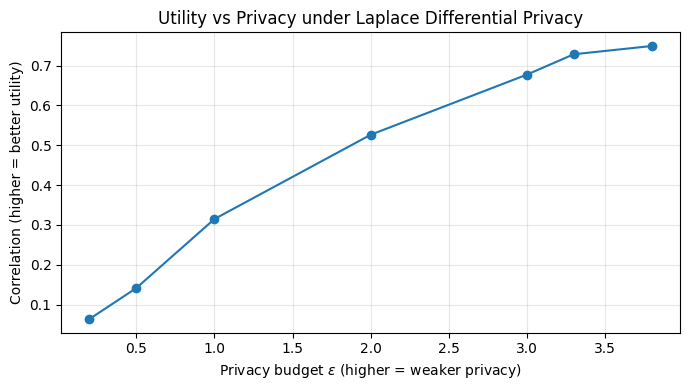

In [100]:
plt.figure(figsize=(7, 4))
plt.plot(results["epsilon"], results["mean_corr"], marker='o', linewidth=1.5)

plt.xlabel("Privacy budget $\\epsilon$ (higher = weaker privacy)")
plt.ylabel("Correlation (higher = better utility)")
plt.title("Utility vs Privacy under Laplace Differential Privacy")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
